In [1]:
!pip install -U spacy==3.*
!python -m spacy download en_core_web_sm
!python -m spacy info

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.

============================== Info about spaCy ==============================

spaCy version    3.7.4                         
Location         /usr/local/lib/python3.10/dist-packages/spacy
Platform         Linux-6.1.58+-x86_64-with-glibc2.35
Python version   3.10.12                       
Pipelines        en_core_web_sm (3.7.1)        



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

from sklearn import metrics
from sklearn import model_selection
from sklearn.datasets import fetch_20newsgroups
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [3]:
training_corpus = fetch_20newsgroups(subset='train')

In [4]:
training_corpus.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [5]:
training_corpus

{'data': ["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",
  "From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washingto

In [6]:
print(training_corpus.target)

[7 4 4 ... 3 1 8]


In [7]:
print(training_corpus.data[0])

first_doc_label = training_corpus.target[0]
print('Label for this post: {}'.format(first_doc_label))
print('Corresponding topic: {}'.format(training_corpus.target_names[first_doc_label]))

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





Label for this post: 7
Corresponding topic: rec.autos


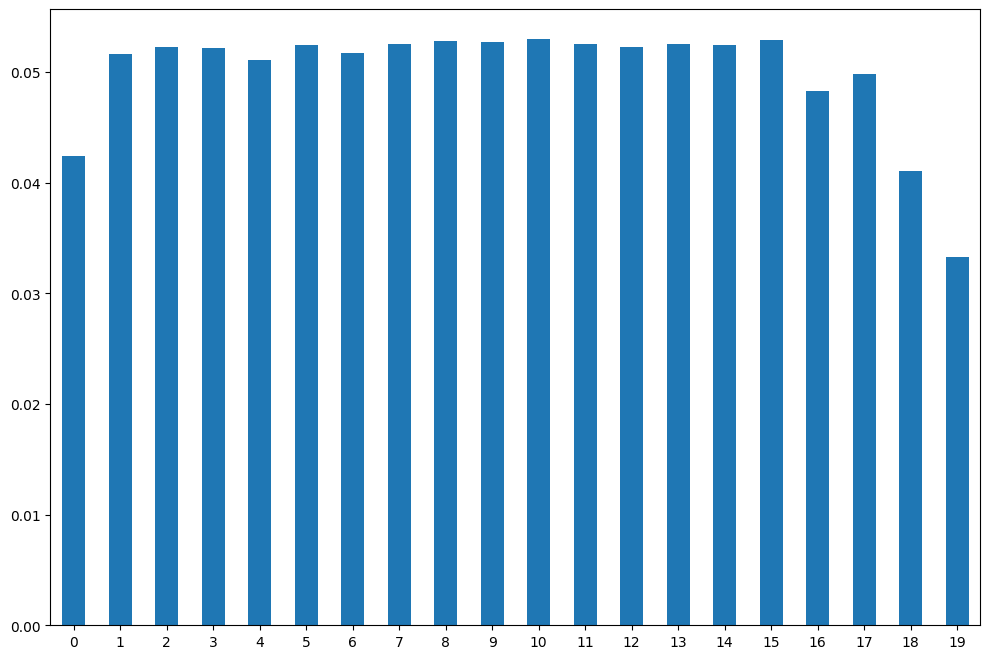

In [8]:
bins, counts = np.unique(training_corpus.target, return_counts=True)
freq_series = pd.Series(counts/len(training_corpus.data))
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_xticklabels(bins, rotation=0)
plt.show()

In [9]:
train_data, val_data, train_labels, val_labels = train_test_split(training_corpus.data, training_corpus.target, train_size=0.8, random_state=1)
print('Training data size: {}'.format(len(train_data)))
print('Validation data size: {}'.format(len(val_data)))

Training data size: 9051
Validation data size: 2263


In [10]:
nlp = spacy.load('en_core_web_sm')

In [12]:
nlp.pipe_names


['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [13]:
nlp = spacy.blank('en')
nlp.pipe_names

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


[]

In [14]:
def spacy_tokenizer(doc):
  return [t.text for t in nlp(doc) if \
          not t.is_punct and \
          not t.is_space and \
          t.is_alpha]

In [15]:
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer)
train_feature_vects = vectorizer.fit_transform(train_data)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [17]:
train_feature_vects.shape

(9051, 60536)

In [18]:
nb_classifier = MultinomialNB()
nb_classifier.fit(train_feature_vects, train_labels)
nb_classifier.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}

In [19]:
train_preds = nb_classifier.predict(train_feature_vects)
print('F1 score on initial training set: {}'.format(metrics.f1_score(train_labels, train_preds, average='macro')))

F1 score on initial training set: 0.8982344792497875


In [26]:
filtered_training_corpus = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
train_data, val_data, train_labels, val_labels = train_test_split(filtered_training_corpus.data, filtered_training_corpus.target, train_size=0.8, random_state=1)

In [24]:
train_feature_vects = vectorizer.fit_transform(train_data)
nb_classifier.fit(train_feature_vects, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


MultinomialNB()

In [27]:
train_preds = nb_classifier.predict(train_feature_vects)
print('F1 score on filtered training set: {}'.format(metrics.f1_score(train_labels, train_preds, average='macro')))

F1 score on filtered training set: 0.791654644597863


In [28]:
%%time
val_feature_vects = vectorizer.transform(val_data)

CPU times: user 4.43 s, sys: 12.9 ms, total: 4.44 s
Wall time: 4.97 s


In [29]:
val_preds = nb_classifier.predict(val_feature_vects)
print('F1 score on filtered validation set: {}'.format(metrics.f1_score(val_labels, val_preds, average='macro')))

F1 score on filtered validation set: 0.6087677070998413


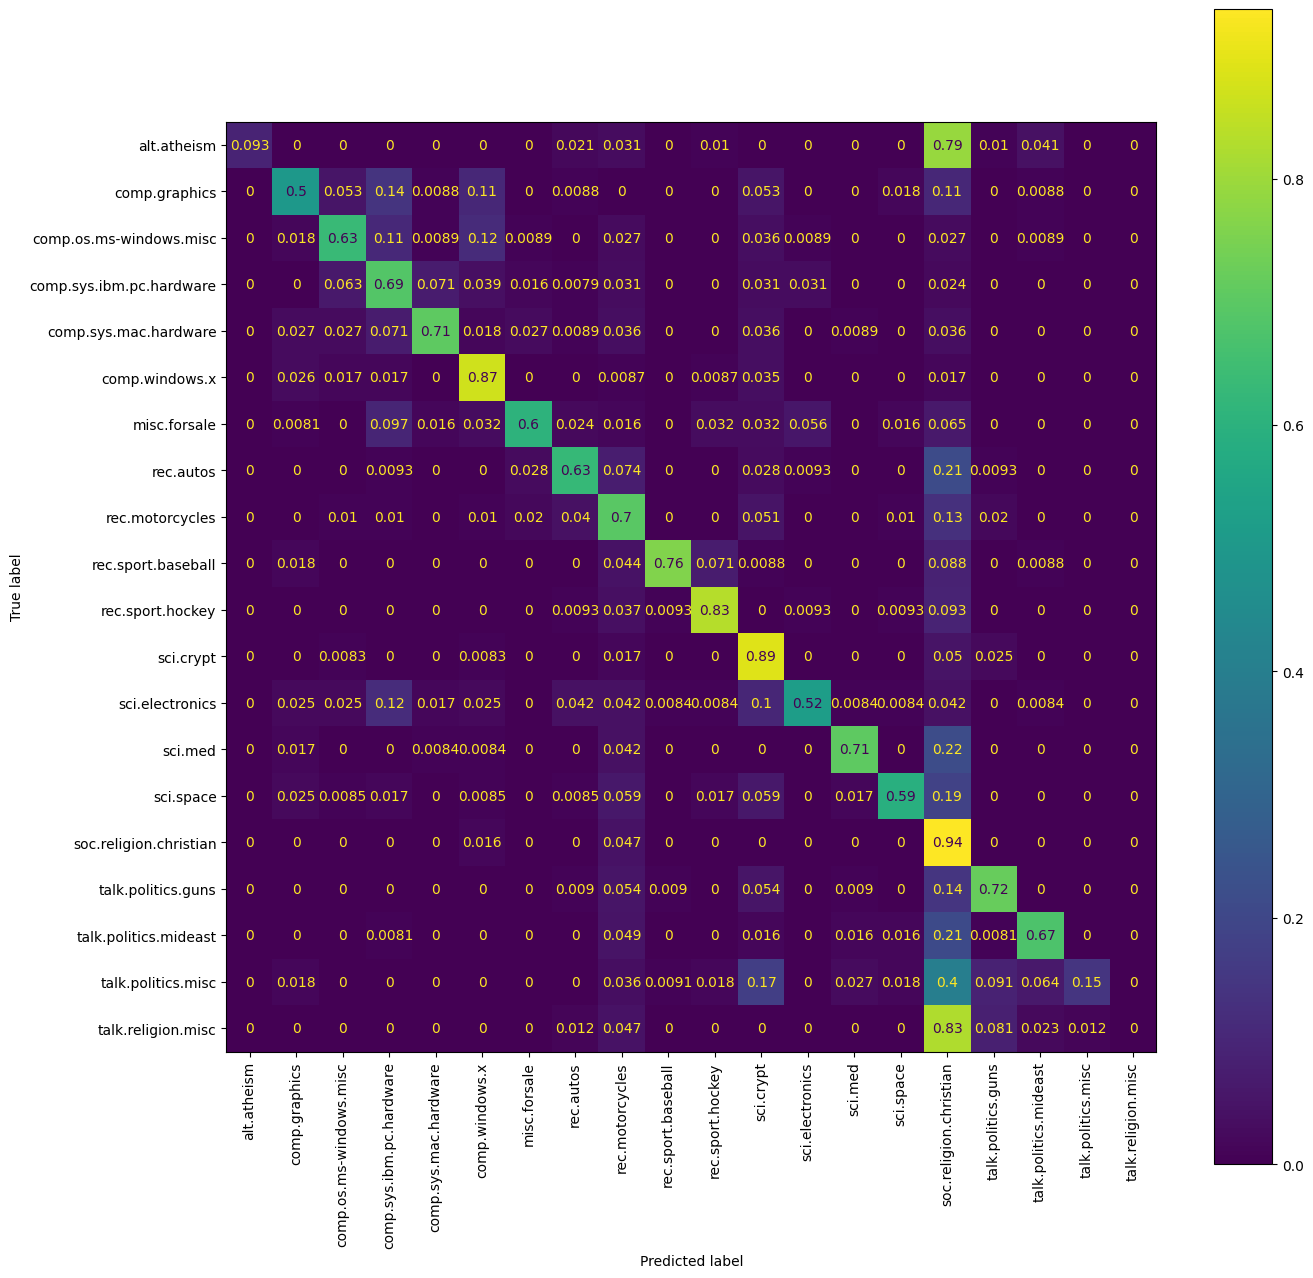

In [30]:
fig, ax = plt.subplots(figsize=(15, 15))

# Create the confusion matrix.
disp = ConfusionMatrixDisplay.from_estimator(nb_classifier, val_feature_vects, val_labels, normalize='true', display_labels=filtered_training_corpus.target_names, xticks_rotation='vertical', ax=ax)

In [31]:
print(metrics.classification_report(val_labels, val_preds, target_names=filtered_training_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       1.00      0.09      0.17        97
           comp.graphics       0.73      0.50      0.59       114
 comp.os.ms-windows.misc       0.74      0.63      0.68       112
comp.sys.ibm.pc.hardware       0.56      0.69      0.61       127
   comp.sys.mac.hardware       0.83      0.71      0.76       112
          comp.windows.x       0.69      0.87      0.77       115
            misc.forsale       0.87      0.60      0.71       124
               rec.autos       0.76      0.63      0.69       108
         rec.motorcycles       0.47      0.70      0.56        99
      rec.sport.baseball       0.96      0.76      0.85       113
        rec.sport.hockey       0.83      0.83      0.83       108
               sci.crypt       0.57      0.89      0.69       120
         sci.electronics       0.82      0.52      0.64       119
                 sci.med       0.89      0.71      0.79       119
         

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
nlp = spacy.load('en_core_web_sm')

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [33]:
unwanted_pipes = ['ner', 'parser']

# Further remove stop words and take the lemma instead of token text.
def spacy_tokenizer(doc):
  with nlp.disable_pipes(*unwanted_pipes):
    return [t.lemma_ for t in nlp(doc) if \
            not t.is_punct and \
            not t.is_space and \
            not t.is_stop and \
            t.is_alpha]

In [34]:
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer)
train_feature_vects = vectorizer.fit_transform(train_data)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [35]:
print('Number of training features: {}'.format(len(train_feature_vects[0].toarray().flatten())))

Number of training features: 42714


In [36]:
nb_classifier.fit(train_feature_vects, train_labels)
train_preds = nb_classifier.predict(train_feature_vects)
print('Training F1 score with fewer features: {}'.format(metrics.f1_score(train_labels, train_preds, average='macro')))

Training F1 score with fewer features: 0.8398883700432671


In [37]:
val_feature_vects = vectorizer.transform(val_data)
val_preds = nb_classifier.predict(val_feature_vects)
print('Validation F1 score with fewer features: {}'.format(metrics.f1_score(val_labels, val_preds, average='macro')))

Validation F1 score with fewer features: 0.6723713085312655


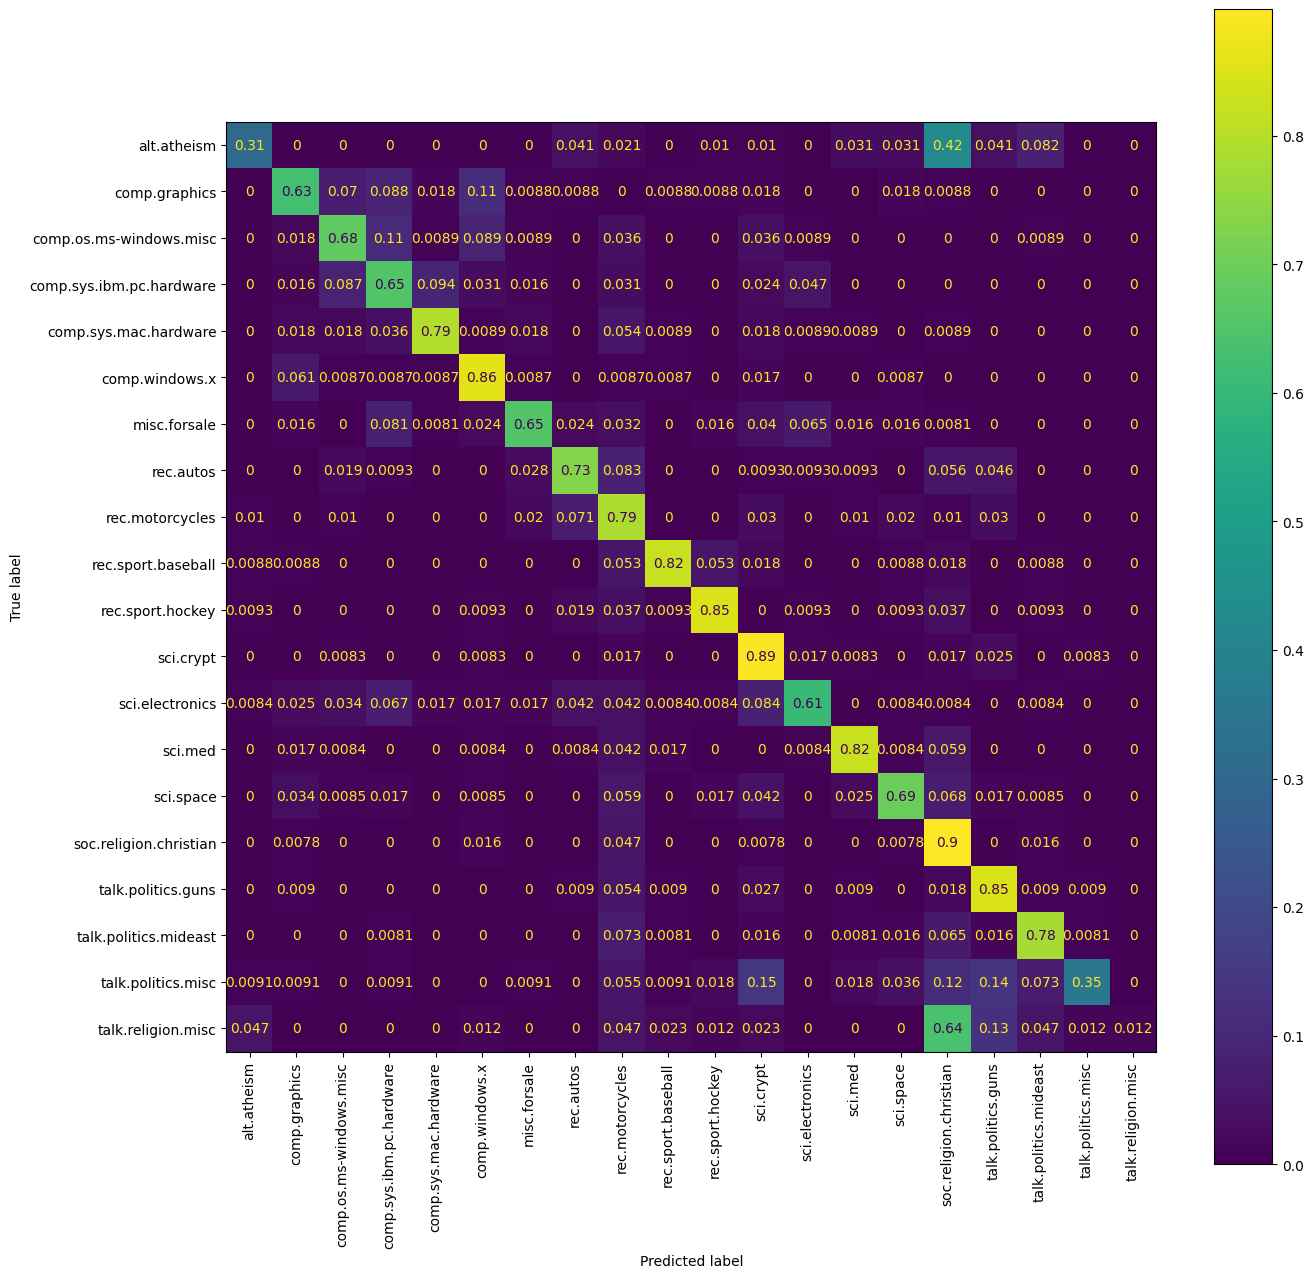

In [38]:
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay.from_estimator(nb_classifier, val_feature_vects, val_labels, normalize='true', display_labels=filtered_training_corpus.target_names, xticks_rotation='vertical', ax=ax)

In [39]:
print(metrics.classification_report(val_labels, val_preds, target_names=filtered_training_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.77      0.31      0.44        97
           comp.graphics       0.72      0.63      0.67       114
 comp.os.ms-windows.misc       0.70      0.68      0.69       112
comp.sys.ibm.pc.hardware       0.62      0.65      0.64       127
   comp.sys.mac.hardware       0.82      0.79      0.81       112
          comp.windows.x       0.71      0.86      0.78       115
            misc.forsale       0.84      0.65      0.74       124
               rec.autos       0.77      0.73      0.75       108
         rec.motorcycles       0.46      0.79      0.58        99
      rec.sport.baseball       0.89      0.82      0.85       113
        rec.sport.hockey       0.85      0.85      0.85       108
               sci.crypt       0.63      0.89      0.74       120
         sci.electronics       0.77      0.61      0.68       119
                 sci.med       0.86      0.82      0.84       119
         

In [40]:
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0,],}

# Instantiate the search with the model we want to try and fit it on the training data.
multinomial_nb_grid = model_selection.GridSearchCV(MultinomialNB(), param_grid=params, scoring='f1_macro', n_jobs=-1, cv=5, verbose=5)
multinomial_nb_grid.fit(train_feature_vects, train_labels)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]},
             scoring='f1_macro', verbose=5)

In [41]:
print('Best parameter value(s): {}'.format(multinomial_nb_grid.best_params_))

Best parameter value(s): {'alpha': 0.01}


In [42]:
best_nb_classifier = multinomial_nb_grid.best_estimator_
val_preds = best_nb_classifier.predict(val_feature_vects)
print('Validation F1 score with fewer features: {}'.format(metrics.f1_score(val_labels, val_preds, average='macro')))

Validation F1 score with fewer features: 0.7321088520594417


In [43]:
print(metrics.classification_report(val_labels, val_preds, target_names=filtered_training_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.68      0.54      0.60        97
           comp.graphics       0.75      0.69      0.72       114
 comp.os.ms-windows.misc       0.72      0.71      0.72       112
comp.sys.ibm.pc.hardware       0.68      0.69      0.68       127
   comp.sys.mac.hardware       0.80      0.79      0.80       112
          comp.windows.x       0.76      0.89      0.82       115
            misc.forsale       0.80      0.61      0.69       124
               rec.autos       0.72      0.71      0.72       108
         rec.motorcycles       0.46      0.81      0.58        99
      rec.sport.baseball       0.90      0.84      0.87       113
        rec.sport.hockey       0.90      0.84      0.87       108
               sci.crypt       0.81      0.87      0.84       120
         sci.electronics       0.72      0.66      0.69       119
                 sci.med       0.88      0.88      0.88       119
         

In [45]:
def show_top_words(classifier, vectorizer, categories, top_n):
  feature_names = np.asarray(vectorizer.get_feature_names_out())
  for i, category in enumerate(categories):
    prob_sorted = classifier.feature_log_prob_[i, :].argsort()[::-1]
    print("%s: %s" % (category, " ".join(feature_names[prob_sorted[:top_n]])))

In [46]:
show_top_words(best_nb_classifier, vectorizer, filtered_training_corpus.target_names, 10)

alt.atheism: god religion atheist people think say atheism post belief believe
comp.graphics: file graphic image thank program format look know color software
comp.os.ms-windows.misc: window file driver problem use program card do thank font
comp.sys.ibm.pc.hardware: drive card controller bus scsi monitor ide mb thank pc
comp.sys.mac.hardware: mac apple drive problem monitor card thank work simms quadra
comp.windows.x: x window server widget motif application use run thank program
misc.forsale: sale offer shipping sell price new include email condition drive
rec.autos: car engine drive like dealer good new buy oil look
rec.motorcycles: bike ride motorcycle dod helmet like rider go think know
rec.sport.baseball: game year team baseball hit win player run fan pitch
rec.sport.hockey: game team play hockey player season playoff nhl win year
sci.crypt: key encryption chip clipper government system nsa phone escrow bit
sci.electronics: power use circuit know like work chip ground try line
sc

In [47]:
# modularized version.

In [48]:
text_classifier = Pipeline([
  ('vectorizer', TfidfVectorizer(tokenizer=spacy_tokenizer)),
  ('classifier', MultinomialNB(alpha=0.01))
])

In [50]:
filtered_test_corpus = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [51]:
%%time
text_classifier.fit(filtered_training_corpus.data, filtered_training_corpus.target)

CPU times: user 3min 34s, sys: 4.77 s, total: 3min 38s
Wall time: 3min 50s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7b2052c17520>)),
                ('classifier', MultinomialNB(alpha=0.01))])

In [52]:
test_preds = text_classifier.predict(filtered_test_corpus.data)

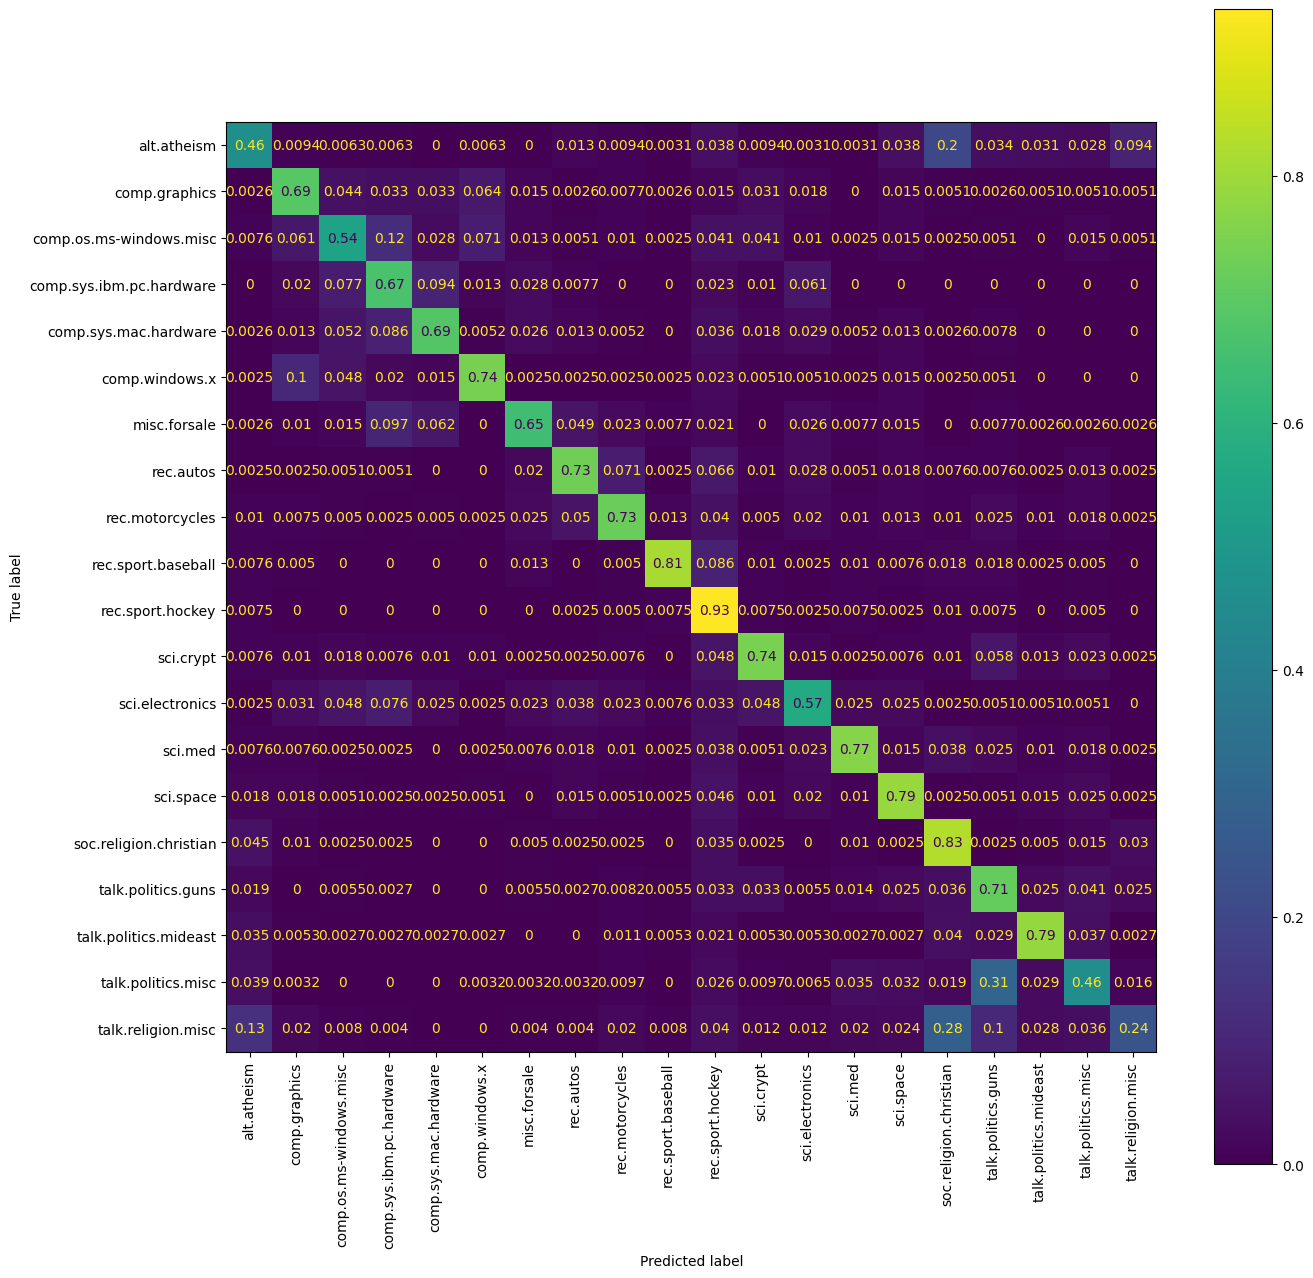

In [53]:
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(filtered_test_corpus.target, test_preds, normalize='true', display_labels=filtered_test_corpus.target_names, xticks_rotation='vertical', ax=ax)
plt.show()

In [54]:
print(metrics.classification_report(filtered_test_corpus.target, test_preds, target_names=filtered_test_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.56      0.46      0.51       319
           comp.graphics       0.68      0.69      0.68       389
 comp.os.ms-windows.misc       0.62      0.54      0.58       394
comp.sys.ibm.pc.hardware       0.59      0.67      0.62       392
   comp.sys.mac.hardware       0.71      0.69      0.70       385
          comp.windows.x       0.80      0.74      0.77       395
            misc.forsale       0.77      0.65      0.70       390
               rec.autos       0.77      0.73      0.75       396
         rec.motorcycles       0.77      0.73      0.75       398
      rec.sport.baseball       0.92      0.81      0.86       397
        rec.sport.hockey       0.58      0.93      0.72       399
               sci.crypt       0.74      0.74      0.74       396
         sci.electronics       0.67      0.57      0.62       393
                 sci.med       0.83      0.77      0.80       396
         

In [55]:
def classify_text(clf, doc, labels=None):
  probas = clf.predict_proba([doc]).flatten()
  max_proba_idx = np.argmax(probas)

  if labels:
    most_proba_class = labels[max_proba_idx]
  else:
    most_proba_class = max_proba_idx

  return (most_proba_class, probas[max_proba_idx])

In [56]:
# Post from r/electronics.
s = "circuit boards contain various compartments and is soldered together."
classify_text(text_classifier, s, filtered_test_corpus.target_names)

('sci.electronics', 0.8093941673774055)